# funkyAD Documentation
## *A package for automatic differentation*

## Introduction
Differentiation is used in many applications, such as finding stationary points of defined functions or minimizing objective loss functions in machine learning applications. 
But differentiating an arbitrary function &#8477;<sup>n</sup> &#8594; &#8477;<sup>m</sup> is generally not an easy task. 
When the function can be expressed as a composition of differentiable elementary functions (which in most cases is true), Automatic Differentiation (AD) can help. 
AD has become one of the most popular techniques for finding derivatives and is often preferred over symbolic differentation and numerical differentiation because of its efficiency and stability.

 <a id='background'></a>
## Background

*Summary*

Why is AD such a popular choice for differentiation? AD takes an input function and breaks it down into a set of elementary functions. Symbolic differentiation is used to calculate the derivatives of the elementary functions. These elementary functions are then combined using common mathematical functions, such as addition or multiplication. The derivatives of the combined functions (which we will refer to as nodes) are calculated using the derivatives calculated from the earlier elementary functions. This process repeats (as more complex functions are combined) until the function's derivative has been calculated. 

This process can be represented using a computational trace or a computational graph. The computational trace is a table that stores the node, its elementary function, their derivatives, and the derivative values evaluated at a given input (if provided). This process can also be visually representated using a computational graph whose nodes are the same as the rows in the computational trace. Nodes are connect to show how nodes are combined and by what elementary operations. 

*Building a computational graph*

As an example, let's visualize $f(x,y)=xy+cos(x+y)$ using a computational graph. 

![title](./img/computational_graph_example.png)

We start with the function's input ($x$ and $y$) as the first nodes ($x_1$ and $x_2$) in our graph. These two inputs are combined by addition ($x+y$) and multiplication ($xy$) to create create two intermediary elementary functions represented by nodes $x_3$ and $x_4$ (notice, we can now rewrite $f(x,y) = xy+cos(x+y)$ as a function of $x_3$ and $x_4$, $f(x_3,x_4) = x_3 + cos(x_4)$). We then take the cosine of $x_4$ to get the intermediatory function $x_5$. Once again, $f(x,y)$ can now be expressed as a function of $x_3$ and $x_5$, $f(x_3,x_5)=x_3 + x_5$. Finally, $x_3$ and $x_5$ are combined by addition to create the final node $x_6$, where $f(x) = x_6$. So the derivative of $f$ is the derivative of $x_6$, which is a function of the derivatives of $x_3$ and $x_6$ which we have computed based on earlier nested functions of nodes.

*Autodifferentiation Implementation: Forward and Reverse Mode*

There are two common methods for implementing AD, forward mode and backward mode (of which the popular backpropagation algorithm for neural networks is a special case). Given a function &#8477;<sup>n</sup> &#8594; &#8477;<sup>m</sup>, forward mode fixes the independent variables or n inputs to solve for m outputs; whereas backward mode fixes the dependent variables or m outputs. This means that forward mode is more efficient when m>>n and backward mode is more efficient when n>>m. As an example of how these two differ, let's return to our previous example, $f(x,y)=xy+cos(x+y)$. 

*Building a computational trace for forward mode*

The evaluation trace is a table where each row is a node and every column stores information about that node. Note that we don't need to build the computational graph before the trace, but it can provide a nice means of visualizing how the function is broken down into a set of nodes. 

Let's walk through building an evaluation trace for our example function $f(x)$. The input nodes are the first rows in the trace. Since they are inputs, they are not broken down into further subcomponents. For this exercise, their current values are $x$ and $y$. Typically we'll be evaluating function and its derivative at a point in the $x,y$ plane. Since the function has two inputs ($x$ and $y$), the derivative will have two dimensions, one for the partial derivative of $f$ with respect to $x$ ($\nabla x$ in our table) and another for the partial derivative of $f$ with respect to $y$ ($\nabla y$ in our table). The values of $\nabla x$ and $\nabla y$ for the inputs are often referred to as the seed vector. In this example our seed vector is $[1, 1]$. 

![title](./img/trace_1.png)

Now, we add the next two intermediate nodes $x_3$ and $x_4$. Notice that the derivative values for each elementary function rely on the derivatives of the inputs to that elementary function. Take $x_3 = x_1 \cdot x_3$, we know, by the product rule, that the derivative is is $x_1 x_3' + x_1' x_3 $ (with respect to either $x$ or $y$). But we have already calculated $x_3'$ and $x_1'$ in earlier rows.

![title](./img/trace_2.png)

Let's complete the table. The final row $x_6=x_3+x_5$ is our function $f$. Plugging in earlier derived values for $x_6' = x_3'+x_5'$, we can find the partial derivatives wrt to $x$ and $y$. This iterative process of building up the derivative from the inputs is the intuition behind foward mode. 

![title](./img/trace_3.png)

This trace has been completed for some abstract $x$ and $y$. In most cases, we want to evaluate the function at a specific value. Using the evaluation trace, we can easily plug these values in to the table to find, for example, the function and its derivative at $(x,y)=(2,1)$:

$$f(2,1) = (2)(1) + cos(2+1) = 2 + cos(3) $$
$$f'(2,1) = [1 - sin(2+1), 2-sin(2+1)] = [1-sin(3), 2-sin(3)] $$ 

*Reverse Mode*

Another option for automatic differenation is reverse mode. In forward mode, you have to calculate the derivative with respect to every input value, e.g. in our example we needed to find the partial derivative wrt $x$ and wrt $y$. If there are many inputs, this can be computationally intense. Reverse mode solves this problem by fixing the dependent variable and working backwards. Of course if there are many outputs, this advantage is lost, so it is best to use reverse mode when there are many inputs and relatively few outputs. 

Reverse model usings the evaluation trace and the chain role to calculate the function's derivative. Recall that we can find the derivative of $f$ with respective to $x$ by finding the partial derivatives with respect to a sub-expression $w$ as follows:

$$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial w}\frac{\partial w}{\partial x}$$

In reverse mode, these subexpression $w$ are the children nodes of our computational graph. For nodes with more than one child, the corresponding derivative according to the chain rule is therefore:

$$\frac{\partial f}{\partial x} = \frac{\partial f}{\partial w_1}\frac{\partial w_1}{\partial x} +  \frac{\partial f}{\partial w_2}\frac{\partial w_2}{\partial x}$$

Let's try reverse mode for our example function $f(x) = xy+cos(x+y)$. We start with the final node $x_6$ and work backwards: 

$$\frac{\partial f}{\partial x_6}=1$$

The final derivative is the seed, which is set to 1.

$$\frac{\partial f}{\partial x_5}=\frac{\partial f}{\partial x_6} \frac{\partial x_6}{\partial x_5} = (1) \frac{\partial (x_3+x_5) }{\partial x_5} = 1\cdot1$$

We already know $\frac{\partial f}{\partial x_6}$. We can sub $x_6$ for its elementary function calculated in the trace ($x_6=x_3+x_5$) and easily take the derivative with respective to $x_5$, which is 1 in this example.

$$\frac{\partial f}{\partial x_4}=\frac{\partial f}{\partial x_5} \frac{\partial x_5}{\partial x_4}=(1) \frac{\partial cos(x_4)}{\partial x_4} = -sin(x_4)$$

Again, we already know $\frac{\partial f}{\partial x_5}$ from the previous step. And we can plug in the elementary function fo $x_5$ using our evaluation trace.

$$\frac{\partial f}{\partial x_3}=\frac{\partial f}{\partial x_6} \frac{\partial x_6}{\partial x_3} = (1) \frac{\partial x_3+x_5}{\partial x_3} = (1)(1)$$

Similar to above, we plug in expressions previously calculated and from the trace.

$$\frac{\partial f}{\partial x_2}=\frac{\partial f}{\partial x_3} \frac{\partial x_3}{\partial x_2} + \frac{\partial f}{\partial x_4} \frac{\partial x_4}{\partial x_2} = (1)  \frac{\partial (x_1 x_2)}{\partial x_2} -sin(x_1+x_2) \frac{\partial (x_1+x_2)}{\partial x_2} = (1)(x_1)-sin(x_1+x_2) (1) $$

Because $x_2$ has children $x_3$ and $x_4$, we need to consider both partial derivatives. We plug in the elementary functions for $x_4$ and $x_3$ using the trace. 

$$\frac{\partial f}{\partial x_1}=\frac{\partial f}{\partial x_3} \frac{\partial x_3}{\partial x_1} + \frac{\partial f}{\partial x_4} \frac{\partial x_4}{\partial x_1} = (1) \frac{\partial x_1 x_2}{\partial x_1} -sin(x_1+x_2) \frac{\partial(x_1 + x_2)}{\partial x_1} = (1) (x_2) - sin(x_1 + x_2) (1)$$


Since $x_1$ and $x_2$ are inputs $x$ and $y$ respectively, we can plug these values back in to find the partial derivatives wrt $x$ and $y$:

$$\frac{\partial f}{\partial x_2} = \frac{\partial f}{\partial y} = x - sin(x+y)$$

$$\frac{\partial f}{\partial x_1} = \frac{\partial f}{\partial x} = y - sin(x+y)$$

This is the same answer we got in forward mode, but we found the partials in just one pass! 

## How to Use funkyAD

The software funkyAD is a software package that the user will interact with using the AD class. This AD class allows the user to differentiate a specified function by wrapping it into an AD object, automatically differentiate it, and access the results. The package is intended for use by developers on personal computers, as a building block on top of which other functionality may be developed. We recommend users download the package using PyPi. A minimal installation in a fresh virtual environment might proceed as follows:

    conda create -n funky python=3.7
    source activate funky

Then, to install funkyAD with PyPi use the following command:

	pip install -i https://test.pypi.org/simple/ funkyAD-funkyADers

    
You are now ready to use the package! Please see examples below.

#### Importing funkyAD after installation

In [2]:
# After installing the package, import base from funkyAD
from funkyAD.base import AD, grad, Node

#### Basic examples of funkyAD

To use funkyAD, the user must pass a function to the AD class that he or she would like to differentiate. The gradient of this function is accessed through AD's grad function. funkyAD supports both scalar and vector functions. 

In [15]:
# exponent example 
def f1(x):
    return x ** 3

ad_object = AD(f1)
print(ad_object.grad(2))
print(ad_object.grad(3))

[[12.]]
[[27.]]


In [13]:
# 2 inputs
def f2(x, y):
    return x + y

print(AD(f2).grad(3, 5))

[[1. 1.]]


In [3]:
# Package supports variable number of inputs/outputs 
import numpy as np
def f3(a: np.array):
    return a.sum()
print(AD(f3).grad(np.array([3, 5, 7])))
print(AD(f3).grad(np.array([3, 5, 7, 9, 11])))

[[1. 1. 1.]]
[[1. 1. 1. 1. 1.]]


In [4]:
# Package supports multiple inputs and outputs
def f4(x):
    return x ** 2, -x, 5 * x
    # equivalently can also return a np.array() object
print(AD(f4).grad(4))

[[ 8.]
 [-1.]
 [ 5.]]


In [10]:
def f4b(x,y): 
    return x*y, x, x**2+y**2
print(AD(f4b).grad(1,2))

[[2. 1.]
 [1. 0.]
 [2. 4.]]


#### Alternative ways to access the gradient
While funkyAD can be directly called as shown above, we have also created a function so that you can get the gradient directly without going through the AD object, in case this is a more intuitve way to get the gradient. The grad method creates the AD object on the function implicitely. 

In [6]:
# One way to get the derivative
def f5(x):
    return x**2

print(AD(f5).grad(1))

# Alternative way
print(grad(f5)(1))

[[2.]]
[[2.]]


#### Using elementary functions in funkyAD
FunkyAD supports many elementary function operations such as addition, subtraction, exponents, and trigonometric functions like cosine, etc. In order to access built in functions that aren't already implicitely overloaded (e.g. addition), you need to import them from the funkyAD functions module. 

In [7]:
from funkyAD.functions import exp 

def f6(x):
    return exp(x)

print(AD(f6).grad(1))


[[2.7182817]]


#### Adding a user-defined arbitrary function
Currently, the package only supports a subset of the possible elementary function that a user might want to use. To extend the library with a new Elementary Function, the user must provide the function and its derivative, and wrap them into a BaseFunction object as follows:

In [8]:
from funkyAD.functions import BaseFunction

def sigmoid(x):
    # Use x.v for the value of x
    return np.exp(x.v) / (1 + np.exp(x.v))

def sigmoid_derivative(x):
    # Use x.v for the value, x.d for the derivative of the argument (x dot)
    return x.d * np.exp(-x.v) / (1 + np.exp(-x.v)) ** 2

sig = BaseFunction(sigmoid, sigmoid_derivative)

print(grad(sig)(3))

[[0.04517666]]


In [9]:
# You can also use sig as a part of a larger function as follows:
def f7(x, y):
    return sig(x ** 2), x + sig(y)
print(grad(f7)(2, 1))

[[0.07065083 0.        ]
 [1.         0.19661194]]


In [36]:
# Multiple input functions are also supported
weird_add = BaseFunction(lambda x, y: 2 * x.v + y.v, lambda x, y: 2 * x.d + y.d)
print(grad(weird_add)(3, 4))

[[2. 1.]]


#### Using funky AD for Newton's Method

funkyAD can be used for more than just deriving derivatives of simple functions. One use case is for root finding. Newton's Method is a root-finding algorithm that finds roots using an iteration approach: 

$$x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)}$$

This algorithm requires calculating the derivative in order to update. funkyAD can be used to find the derivative in this case. Take the function $f(x)=x^2+x$. It has two roots, one at -1 and another at 0. Using Newton's Method we can find both these roots by using different initialization points (e.g. if we always pick a positive initialization point, then the only root it will find is 0). Please see below for the code and results. 

In [37]:
import numpy as np
import matplotlib.pyplot as plt

In [38]:
# create newton root method using funkyAD to find the Jacobian of the function
def newtonroot(f, x):
    fx = f(x)
    dfx = AD(f).grad(x) # alternatively this can be written grad(f)(x)
    x_next = x - fx/dfx 
    return x_next 

def get_root(f,x_start):
    delta = 10
    path = [x_start]
    x = x_start
    while delta > 1e-6:
        new_x = newtonroot(f,x) 
        path.append(new_x)
        delta = abs(x - new_x)
        x = new_x 
    return(x, path)

In [41]:
# root method for scalar function (e.g. y = f(x))
def f(x):
    return x**2+x 

# try one initialization
zero1, path1 = get_root(f, 1)

# try a different initialization 
zero2, path2  = get_root(f, -2)
print(zero1, zero2)

[[0.]] [[-1.]]


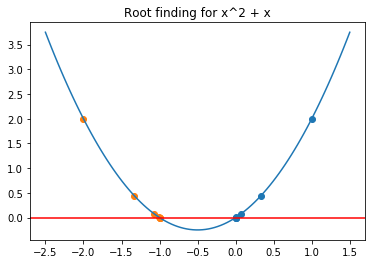

In [40]:
xs = np.linspace(-2.5, 1.5, 100)
path1_ys = [f(x) for x in path1]
path2_ys = [f(x) for x in path2]


plt.plot(xs, f(xs))
plt.axhline(y=0, color='r', linestyle='-')
plt.scatter(path1, path1_ys)
plt.scatter(path2, path2_ys)
plt.title(r'Root finding for $x^2 + x$')
plt.show()

## Software Organization

#### Directory Structure: 
```
.
| README.md
| LICSENSE
| requirements.txt 
| setup.py
| .travis.yml
| .gitignore 
| 
|--docs
|  | documentation.ipynb 
|  | milestone1.md
|  | milestone2.ipynb
|  |-img
|. |-benchmarks
|  |-examples
|  | |- AD_users_intro.ipynb 
|  | |- example1.py
|  | |- trace.py
|
|--src/funkyAD
|  | __init__.py 
|  | base.py
|  | functions.py 
|  | helpers.py
|
|--tests
|  | test_base.py
|  | test_functions.py
|  | test_helpers.py
```

#### Modules (functionality)

The funkyAD package stored within the \src directory contains 3 modules: `base.py`, `functions.py`, and `helpers.py`. 

The **base module** defines the AD class and the Node class. The AD class takes a function as an input and initiates forward or reverse mode to find the gradient of the function at a given value. The input function is broken down into nodes (defined by the Node class) which store the value (Node.v) and derivative (Node.d) for each input and combined nodes, leveraging the properties of dual numbers. 

The **functions module** defines the values and derivatives of elementary functions (e.g. sin, exponents, addition, and multiplication). Since we are working with Node objects, the Base Function class converts the inputs into nodes and then defines the corresponding value and derivative for the output node. As an example, consider if we were trying to define the elementary function multiplication with two inputs, $x^2$ and $y$. We return an output node whose values and derivatives defined based on the symbolic differentiation for multiplication, so in our example, the output node is Node($x^2+y, 2xy + x^2)$.

The **helpers module** includes helper functions such as figuring out the number of inputs in a function and turning all inputs into nodes. 

### Test suite
Our test suite consists of doctests, PyTest, TravisCI, and CodeCov. Pytest is used to run automated tests. TravisCI is used to run the tests when a pull request is made to merge changes into master, so that we only publish code bases that successfully build. CodeCov is used to track code coverage (percentage of functions covered by tests) with each build and through the code base history.

Importantly, testing is done against an installed version of the code base. This is how users will interact with the package, and for development purposes avoids problems of Python being confused between imports of `funkyAD` referring to an installed package or a local library. With the application code moved within a `src` directory and tests run against an installed version, there will be no conflicts.

##### Continuous integration
The test suite automatically runs with pytest on Travis CI whenever an edit to the production code is initiated. The package contains the `YAML` manifest for Travis, which specifies what dependencies to install and does so automatically, before running the tests every time a pull request (or push) is made to update the code in the master branch.

We have three sets of unit tests: `test_base.py`, `test_functions.py`, and `test_helpers.py`, for each module respectively. They check for basic functionality of classes and functions, test that exceptions are handled properly, and verify that our functions work in various edge cases and with different input arrays.  

##### A word on package structure
Rather than being placed among the application code, the tests are in a `/tests` folder in the root directory. Every time Travis runs, it sets up a virtual environment with Python, installs our package dependencies, then installs the package from the local source code using the `setup.py` file (not the version published in PyPi, as that does not contain the latest changes)

This design choice boils down to whether tests should be placed in and run against source code in the same directory, or placed outside the code base and run against an installed version of the code base (i.e. the package). The former is easier to implement and to use for ad hoc experimentation, but the latter separates the tests from the package itself, which is more robust and has several advantages:
1.	Some tests require additional dependencies beyond those of the package, starting with `pytest` itself. The user shouldn’t need to install these as well in order to use the package, which doesn’t actually require them.
2.	Most users will not run the tests, assuming rather that the developers tested it properly before publishing it. As such, tests are part of the distribution, but not directly part of the package.
3.	It avoids the issue where there is both an installed version of the package and the local source code, in which case imports can be unreliable in which version they import.
4.	Developers can more safely edit tests without accidently editing source code.
5.	It forces developers to install the distribution in order to run tests, meaning you both test that it is packaged correctly and avoid tests failing for the wrong reasons.
In practical terms, separating tests from the package means nesting the package one level deeper, we following a common convention and wrap it in a src directory, with tests in a separate tests directory in the distribution.

##### Running the tests
As with using the package, we recommend running tests in a virtual environment. First, set up a virtual environment, in this example called funky:

    conda create -n funky python=3.7 anaconda
    conda activate funky

Then you can either install the funkyAD package via PyPi:

    pip install -i https://test.pypi.org/simple/ funkyAD-funkyADers

Or by installing the local source code on your machine from inside the cloned repo:

    pip install -r requirements.txt
    pip install -e .

The `-e` flag makes the source code editable, so that you can make changes to the code base and re-run tests without having to reinstall the package from the updated local source code every time you make a change.

So far the only packages installed in your new virtual environment are those listed in the requirements file. This does not include the packages necessary to run the unit tests, as most users will not be needing that. In order to run the tests, you will need to install pytest and, optionally, codecov: 
    
    pip install pytest pytest-cov
    pip install codecov

Now you can run all tests in the test suite via:

    pytest --cov funkyAD

Where the `--cov` flag is optional depending on whether you want to see reports on code coverage.

### Software Packaging & Distribution 

The funkyAD package will be distributed with PyPI. Consequently, users will be able to install the package using the ubiquitous pip package manager. It will follow the guidelines and instructions in the official Python documentation. 

	pip install -i https://test.pypi.org/simple/ funkyAD-funkyADers

We recommend using a virtual environment, which can be started with the following command before downloading the package: 

	conda create -n env_name python=3.7 anaconda
	source activate env_name


## Implementation

funkyAD has three modules (`base.py`, `functions.py`, and `helpers.py`), which we will describe in more detail here.

##### `base.py`

*AD Class* - The AD class takes a function as input and has four parameters for storing the function (`self.f`), the seed (`self.seed`), the input dimension (`self.n`), the output dimension (`self.m`), and the trace (`self.trace`). The input function is initialized automatically but the remaining parameters are not filled in until the user either gralls AD's grad function to run forward mode, which calls AD's private function `\_forward` to find the derivative of the function at the values specified in the grad function using forward mode (e.g. AD(f).grad(2) finds the gradient of function f at 2). `\_forward` first determines the number of inputs and outputs (self.n and self.m, respectively) in the given function. We handle non-scalar functions by storing everything in ndarrays. After determining the dimension of the inputs and outputs,`\_forward` sets the seed if the user hasn't done that already, checking to make sure the seed is of the right dimension and input type. Then, `\_forward` calls the helper function `nodify` to convert all values to Nodes (described below), which are returned to the grad function and the derivatives returned to the user as an ndarray using the helper function `\_unpack`. 

*Node Class* - The Node class defines a node, which has two main parameters: a value and a derivative. Nodes are connected and can be added or multiplied together to form new nodes, via the dunder methods`\_\_add\_\_` etc. These dunder methods are overloaded with elementary functions defined in the functions.py file. We check to make sure all values and derivatives are numeric, i.e. it does not support strings. While the behavior for the common set of operatures ($+, \times, sin,$ etc.) is known, we make our own design choices for comparision operators. For equality (=) and inequality (!=) comparisons of nodes, we check that both the value and the derivative ar the same or that either differ, respectively. For comparison operators ($<, <=, >, >=$), we only use the value of the node and ignore the derivatives. 


*Grad function* -  As syntatic sugar, we also define a function `grad` which calls the AD class implicitely to return the gradient.  

<font color='red'> This is the forward mode component of our package, please refer to the [Extension](#extension) section for details on how reverse mode is implemented.</font> 


##### `functions.py` 

The Base Function class converts inputs into nodes and then defines the corresponding value and derivative for the output node. As an example, consider if we were trying to define the elementary function multiplication with two inputs, $x^2$ and $y$. We return an output node whose values and derivatives defined based on the symbolic differentiation for multiplication, so in our example, the output node is Node($x^2+y, 2xy + x^2)$.

funkyAD currently supports the elementary functions: multiplication, division, power, sqrt, positive, negativ, absolut value, invert, round, floor, ceiling, trunc, exponentials, sin, cos, tan, arcsin, arccos, arctan, sinh, cosh, tanh, and sigmoid. The user can use elementary functions by importing them with the following line of code: 

    from funkyAD.functions import exp 

We also allow the user to add their own elementary function to the list if we do not include the elementary function they need in the initial library list. An appropriate exception is raised if the user tries to utilize a function that is not defined as an instance of the ElementaryFunction class.

##### `helpers.py` 

Helpers defines important functions called by the AD class to perform autodifferentation: 

`count_recursive` takes args as input and counts the number of arguments. It is used to determine the number of inputs or outputs for a given function. 

`count_recursive_recursion_part` is a helper for `count_recursion` function that performs the recursion.

`unpack` takes nested arrays or lists and creates a depth 1 list. This is useful for iterating  through outputs to return the derivative stored at each output node. 

`unpack_recursion_part` is a helper for *unpack* that performs the recursion.  

`nodify` turns all inputs into nodes, storing both the value and derivative. To do this, it first checks whether each item in the args list is a ndarray, list, or other object. Depending on the type of object, it recursively sets each element in the ndarray, list, or other object as a Node with a value and a derivative and appends this to a list using the augment function defined within nodify. 

`recursive_append` is a helper for building the trace by storing the nodes in a list.

#### External dependencies

Our software package relies on numpy, which is specified in the "requirements.txt" file in the root directory. The testing suite reiles on pytest, pytest-cov, and codecov. Testing dependencies are specified in the ".travis.yml" file also in the root directory.

 <a id='extension'></a>
## Extension: Reverse mode 

As an additional feature, we have also implemented reverse mode. Similar to forward mode, reverse mode is called using the AD class defined in `base.py`. Users can specify that they'd like to use reverse mode rather than forwad mode by changing the `mode` parameter of the AD class, through the `set_mode` function, to 'reverse'. The current default is 'forward'. After changing the default, the user calls the `grad` function as usual to find the derivative of the function.

The `grad` function now calls two different methods depending on whether we are in forward or reverse mode. Forward mode calls the `\_forward` method in AD (explained above). Reverse mode calls the `\_reverse` method. The first step in implementing reverse mode is to store the trace (self.trace), so the `\_reverse` method startings by calling the `\_buildtrace` to create the trace. The hierarchy of the trace is mantained by each node keeping track of its parents. This required extending the Node class to include a `parents` parents parameter which points to the parent nodes of each node, if they exist. The `recursive_append` method in the `helpers.py` builds the list recursively. Once the trace has been built (in `\_buildtrace`), it returns thte trace to the `\_reverse` method. The `\_reverse` method then loops through the trace, calculating the partial derivatives along the way using the chain rule (see [Background](#background) ) for details). Finally we return the gradient.

### How to use revese mode in funkyAD

funkyAD is defaulted to use 'forward' mode, so if you would like to instead use 'reverse' mode, you must set the mode to reverse mode with the *set_mode* function:

In [5]:
def f1(x,y):
    return x**2 + y

adobj = AD(f1)
adobj.set_mode('reverse')

After setting reverse mode, you can use the same functionality as forward mode to find your gradients. Below, we provide some examples. 

In [6]:
adobj.grad(1, 1)

array([[2., 1.]])

In [8]:
def f2(x,y):
    return [x+y, x**2]

adobj = AD(f2)
adobj.set_mode('reverse')

adobj.grad(1,1)

array([[1., 1.],
       [2., 0.]])

We can set it back to forward mode the same way, with `adobj.set_mode('forward')`, but new AD object will automatically call forward mode so the user must specify reverse mode each time a new AD object is called. 

In [14]:
def f3(x,y):
    return x**2+x

adobj = AD(f3)
adobj.set_mode('forward')
adobj.grad(1,1)

array([[3., 0.]], dtype=float32)

### The benefits of reverse mode

Reverse mode can be more efficient than forward mode in situations when there are far more inputs than outputs. As an example consider a function that sums all of its inputs, so $f(x_1, x_2, ..., x_n) = x_1 + x_2 + ... + x_n$. As $n$ grows, reverse mode will find the gradient faster than reverse mode. In the figure below, we see that up until about 2000 inputs, the two modes perform similarily, but after this point, forward mode time begins to grow at a much faster rate than reverse mode. At 8000 inputs, reverse mode is about twice as fast, and at 10,000 it is more than 3 times as fast. 

![title](./img/fwd_rev_increasing_n.png)